<a href="https://colab.research.google.com/github/edsonportosilva/OptiCommPy/blob/main/examples/test_modulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Test clock Recovery 

In [1]:
if 'google.colab' in str(get_ipython()):    
    ! git clone -b main https://github.com/edsonportosilva/OptiCommPy
    from os import chdir as cd
    cd('/content/OptiCommPy/')
    ! pip install . 

In [2]:
from optic.dsp.core import firFilter, pulseShape, pnorm, upsample, clockSamplingInterp
from optic.utils import parameters
from optic.plot import pconst, plotPSD
from optic.comm.modulation import modulateGray
from optic.comm.metrics import fastBERcalc
import matplotlib.pyplot as plt
import numpy as np
from numba import njit

from optic.models.devices import adc
from optic.dsp.clockRecovery import gardnerClockRecovery

In [3]:
%load_ext autoreload
%autoreload 2

## Test clock recovery

sampling clock deviation (ΔFs) = 25.00 ppm


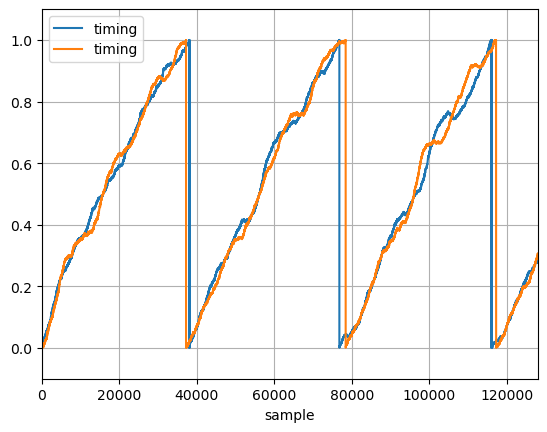

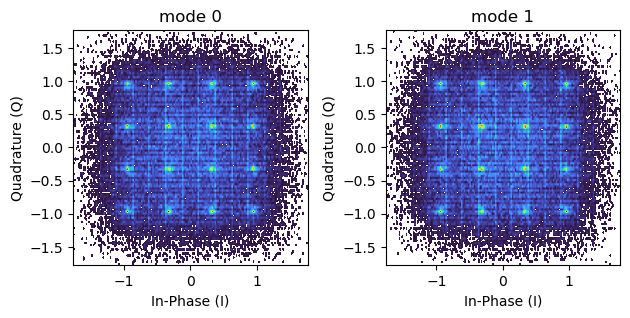

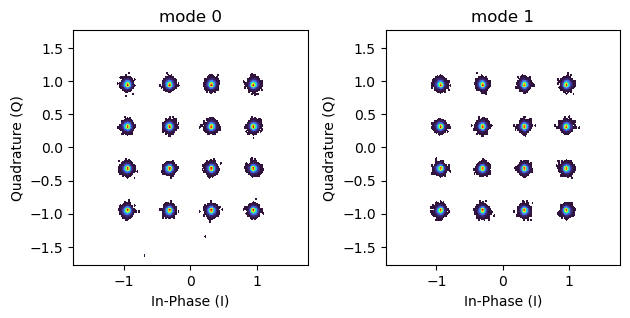

Mode 0: BER = 0.00e+00
Mode 1: BER = 0.00e+00


In [49]:
# simulation parameters
SpS = 16          # samples per symbol
M = 16            # order of the modulation format
Rs = 32e9         # Symbol rate (for OOK case Rs = Rb)
Fs = SpS*Rs       # Sampling frequency in samples/second
Ts = 1/Fs         # Sampling period

# generate pseudo-random bit sequence
bitsTx = np.random.randint(2, size=int(np.log2(M)*128e3))

# generate ook modulated symbol sequence
symbTx = modulateGray(bitsTx, M, 'qam')    
symbTx = pnorm(symbTx) # power normalization

symbTx = symbTx.reshape(-1,2)

# upsampling
symbolsUp = upsample(symbTx, SpS)

# typical NRZ pulse
pulse = pulseShape('rc', SpS, N=4001, alpha=0.001)
pulse = pulse/max(abs(pulse))

# pulse shaping
sigTx = firFilter(pulse, symbolsUp)

# resample signal to non-integer samples/symbol rate
ppm = 25
Fs_adc = 2*Rs*(1 + ppm/1e6)
ppm_meas = (Fs_adc-2*Rs)/(2*Rs)*1e6

print(f'sampling clock deviation (ΔFs) = {ppm_meas:.2f} ppm')

# ADC input parameters
paramADC = parameters()
paramADC.Fs_in = Fs
paramADC.Fs_out = Fs_adc
paramADC.jitter_rms = 400e-15
paramADC.nBits =  8
paramADC.Vmax = 2.5
paramADC.Vmin = -2.5
paramADC.AAF = False
paramADC.N = 1001

sigRx = adc(sigTx, paramADC)

# clock recovery with Gardner's algorithm
paramCLKREC = parameters()
paramCLKREC.isNyquist = True
paramCLKREC.returnTiming = True
paramCLKREC.ki = 1e-6
paramCLKREC.kp = 5e-4
paramCLKREC.lpad = 0#8
#paramCLKREC.nSymbols = 128000//2

outCLK, ted_values = gardnerClockRecovery(sigRx, paramCLKREC)

# plot curve of estimated timmig error over time
plt.figure()
plt.plot(ted_values, label = 'timing')
plt.xlabel('sample')
plt.grid()
plt.xlim([0, len(sigRx)])
plt.ylim([-0.1, 1.1])
plt.legend()

# plot received constellations without and with clock recovery
discard = 10000
pconst(sigRx[discard::2], pType='fancy');
pconst(outCLK[discard::2],pType='fancy');

# Check BER
symbRx = outCLK[0::2,:]
BER, _, _ = fastBERcalc(symbRx[discard:-discard,:], symbTx[discard:-discard,:], M, 'qam')

for indMode in range(BER.shape[0]):
    print(f'Mode {indMode}: BER = {BER[indMode]:.2e}')

In [ ]:
plotPSD(ted_values-np.mean(ted_values),NFFT=ted_values.shape[0], Fs=2*Rs)
plt.xlim(-500e6, 500e6)